## **Setup**

In [1]:
# Import the necesary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
config = {
    # Basic information
    "AUTHOR": "Kiernan",
    
    # Training params
    "LR": 0.001,
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
    
    # Model params
    "FIRST_FILTERS": 16,
    "CONV_LAYERS": 4,
    "N_FILTERS": 8,
    "KERNEL_SIZE": (3,3),
    "EMBEDDING_SIZE": 16,
    "DROPOUT": 0.2
}

## **Initialize WANDB**

In [3]:
import wandb
from wandb.keras import WandbCallback
from secrets import WANDB
wandb.login(key=WANDB)
run = wandb.init(project="deep-clustering-evaluation", entity="kmcguigan", group="base-model", config=config, job_type="train")

wandb: Currently logged in as: all-off-nothing (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kiern/.netrc
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## **Loading Data**

In [4]:
with open('data/train.npy', mode='rb') as infile:
    X_train = np.load(infile, allow_pickle=True)
    y_train = np.load(infile, allow_pickle=True)

with open('data/val.npy', mode='rb') as infile:
    X_val = np.load(infile, allow_pickle=True)
    y_val = np.load(infile, allow_pickle=True)

with open('data/test.npy', mode='rb') as infile:
    X_test = np.load(infile, allow_pickle=True)
    y_test = np.load(infile, allow_pickle=True)

print(f"Train data shape: {X_train.shape} Val data shape: {X_val.shape} Test data shape: {X_test.shape}")

Train data shape: (50000, 28, 28, 1) Val data shape: (10000, 28, 28, 1) Test data shape: (10000, 28, 28, 1)


## **Create Model**

In [5]:
def create_body(image_shape):
    inputs = tf.keras.layers.Input(shape=image_shape)
    
    def conv_block(layer_inputs, n_filters, kernel_size, **kwargs):
        x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same", **kwargs)(layer_inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        return x
    
    x = conv_block(inputs, config["FIRST_FILTERS"], config["KERNEL_SIZE"], strides=2)
    for _ in range(config["CONV_LAYERS"]):
        x = conv_block(x, config["N_FILTERS"], config["KERNEL_SIZE"])
    
    x = tf.keras.layers.Conv2D(config["EMBEDDING_SIZE"], (1,1), padding="same")(x)
    outputs = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="body")

body = create_body(X_train.shape[1:])
body.summary()

Model: "body"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 8)        32        
 hNormalization)                                              

In [6]:
def create_head(n_classes):
    inputs = tf.keras.layers.Input(shape=(config["EMBEDDING_SIZE"]))
    x = tf.keras.layers.Dropout(config["DROPOUT"])(inputs)
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="head")

head = create_head(10)
head.summary()

Model: "head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [7]:
model = tf.keras.models.Sequential([
    body,
    head
],
    name="combinedModel"
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "combinedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 body (Functional)           (None, 16)                3408      
                                                                 
 head (Functional)           (None, 10)                170       
                                                                 
Total params: 3,578
Trainable params: 3,482
Non-trainable params: 96
_________________________________________________________________


## **Training**

In [8]:
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 batch_size=config["BATCH_SIZE"],
                 validation_batch_size=config["BATCH_SIZE"],
                 epochs=config["EPOCHS"],
                 callbacks=[stopper, lr_reducer, WandbCallback(predictions=8, input_type='images', validation_data=(X_val, y_val))])

body.save(os.path.join(run.dir, "body.h5"))
head.save(os.path.join(run.dir, "head.h5"))

Epoch 1/30
1563/1563 [==============================] - 27s 16ms/step - loss: 0.9182 - sparse_categorical_accuracy: 0.7005 - val_loss: 0.7273 - val_sparse_categorical_accuracy: 0.7724 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.2952 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.3442 - val_sparse_categorical_accuracy: 0.8976 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.2151 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.2262 - val_sparse_categorical_accuracy: 0.9294 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - 27s 17ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.7857 - lr: 0.0010
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.1571 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.6546 - val_sparse_categorical_accuracy: 0.7624 - lr: 0.0010
Epoch 6/30
1563

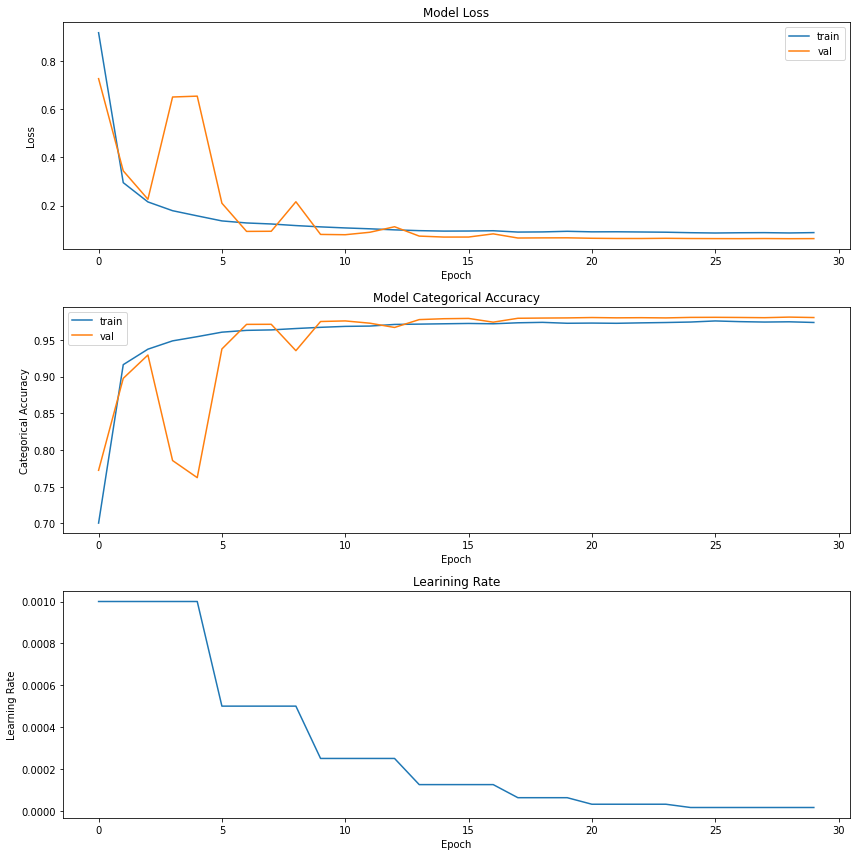

In [9]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

plt.subplot(311)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(312)
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.title('Model Categorical Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(313)
plt.plot(hist.history['lr'])
plt.title('Learining Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')

run.log({'train_graph': wandb.Image(fig, caption="Training Graph")})
plt.show()

In [10]:
ev = model.evaluate(X_test, y_test)
run.log({'test/loss':ev[0], 'test/categorical_accuracy':ev[1]})

313/313 [==============================] - 2s 5ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9816


## **Analyze Test Results**

In [11]:
preds = model.predict(X_test)
cf = confusion_matrix(y_test, np.argmax(preds, axis=-1))
cf

array([[ 968,    1,    2,    3,    0,    0,    5,    0,    1,    0],
       [   1, 1125,    3,    1,    0,    2,    2,    1,    0,    0],
       [   1,    0, 1016,    2,    1,    1,    3,    5,    1,    2],
       [   0,    0,    1, 1001,    0,    4,    0,    1,    2,    1],
       [   0,    1,    1,    0,  953,    0,    4,    2,    2,   19],
       [   1,    0,    1,   10,    0,  873,    2,    2,    2,    1],
       [   6,    2,    3,    0,    1,    0,  943,    0,    3,    0],
       [   0,    2,   10,    1,    0,    0,    0, 1007,    0,    8],
       [   2,    1,    2,    4,    0,    0,    1,    1,  956,    7],
       [   0,    1,    3,   10,   10,    2,    1,    4,    4,  974]],
      dtype=int64)

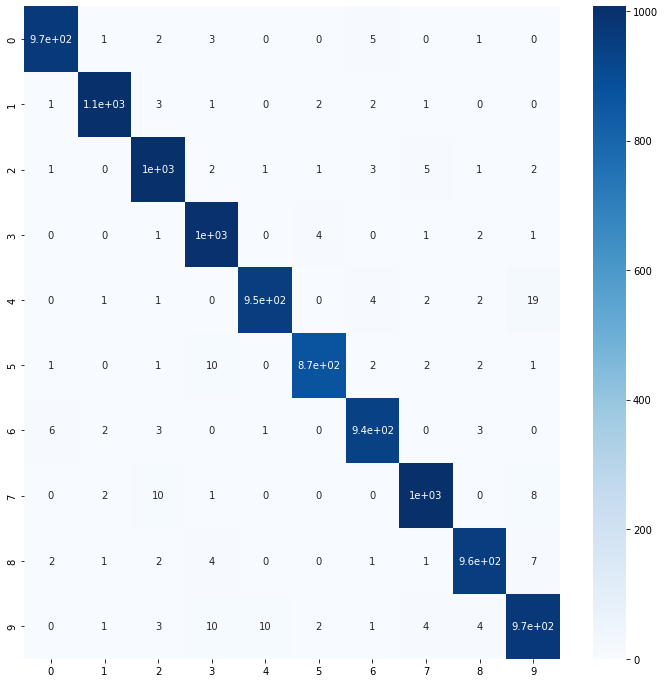

In [12]:
class_names = [x for x in range(0, 10, 1)]
fig = plt.figure(figsize=(12,12))
sns.heatmap(cf, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues', robust=True)
run.log({'confusion_matrix': wandb.Image(fig, caption="Confusion Matrix")})
plt.show()

In [13]:
run.log({
    "testExamples": [wandb.Image(im, caption=f"Pred:{pred} Lable:{y}")
                        for im, pred, y in zip(X_test[:16,:,:,:], np.argmax(preds[:16], axis=-1), y_test[:16])]
})

In [14]:
run.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▆▇▇▇█████████████████████████
test/categorical_accuracy,▁
test/loss,▁
val_loss,█▄▃▇▇▃▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▅▆▂▁▇██▇█████████████████████
best_epoch,28
best_val_loss,0.06225
epoch,29
